# Notebook For Final Results Figures and Tables

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib import rcParams
import csv
import collections
import time
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split, cross_validate # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [9]:
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [6]:
files = ['1D_All_ReplaysData_PvP.csv', '1D_All_ReplaysData_PvT.csv', '1D_All_ReplaysData_PvZ.csv', '1D_All_ReplaysData_TvT.csv', '1D_All_ReplaysData_TvZ.csv', '1D_All_ReplaysData_ZvZ.csv', "StarCraft_Combined_Dataset.csv"]

## Baseline Models Accuracy Table

In [37]:
# Create df for adding performance of different models
df = pd.DataFrame(columns=['File', 'Model', 'Score', 'Percentile'])
df_list = []  # Initialize an empty list to store DataFrames to concatenate later.

for file in files:
    # Load the data
    data = pd.read_csv('../'+ file)

    # Assuming combined_data is your DataFrame
    data = data.drop(data[data['Winner'] == 0].index)
    
    data = data.drop(data[data['Winner'] > 2].index)
    # Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
    label_encoder = LabelEncoder()
    # convert 1 to 0 and 2 to 1
    data['Winner'] = data['Winner'].replace(1, 0)
    data['Winner'] = data['Winner'].replace(2, 1)

    label_encoders = {}
    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])



    for per in range(1,11, 1):
        percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per/10)

        def find_nearest_row(group):
            nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
            return group.loc[[nearest_index]]

        # Apply the function to each group of 'ReplayID' and concatenate the results
        nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)
        # Reset the index if needed
        nearest_rows.reset_index(drop=True, inplace=True)

        # Standardize the data.
        scaler = StandardScaler()
        nearest_rows[nearest_rows.columns.drop(['Winner'])] = scaler.fit_transform(nearest_rows[nearest_rows.columns.drop(['Winner'])])

        # Define features (X) and target variable (y)
        X = nearest_rows.drop(['Winner'], axis=1)
        y = nearest_rows['Winner']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42) 

        # Dictionary to hold scores for the models
        scores_dict = {'File': file, 'Percentile': per/10}
                
        # Build the models and evaluate them
        models = {
            'RandomForest': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=12, max_features=23, min_samples_split=30, random_state=63),
            'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=1000, C=0.1, penalty='l1'),
            'SVM': svm.LinearSVC(C=0.00001, random_state=42, dual=False, max_iter=1000),
            'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance'),
            "Neural Network": tf.keras.models.Sequential([
                tf.keras.layers.Dense(250, activation='sigmoid', input_shape=(X_train.shape[1],)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(125, activation='sigmoid'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        }

        for model_name, model in models.items():
            if model_name == "Neural Network":
                # Compile the model.
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

                # Train the model.
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

                # Evaluate the model.
                loss, accuracy = model.evaluate(X_test, y_test)
                score = accuracy
            else:
                # Train and score the model
                # model.fit(X_train, y_train)
                # score = model.score(X_test, y_test)

                cv_scores = cross_val_score(model, X, y, cv=5)  # You can adjust the number of folds (cv parameter) as needed
                score = cv_scores.mean()

            scores_dict[model_name] = score

        print(scores_dict)
        # Append the scores_dict as a DataFrame to df_list
        df_list.append(pd.DataFrame([scores_dict]))
    print(file, " Done!")

df = pd.concat(df_list, ignore_index=True)

3/3 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.6712
{'File': '1D_All_ReplaysData_PvP.csv', 'Percentile': 0.1, 'RandomForest': 0.6730974124809741, 'LogisticRegression': 0.7198630136986301, 'SVM': 0.6677321156773212, 'KNN': 0.6564307458143075, 'Neural Network': 0.6712328791618347}
3/3 [==============================] - 0s 2ms/step - loss: 0.8311 - accuracy: 0.6438
{'File': '1D_All_ReplaysData_PvP.csv', 'Percentile': 0.2, 'RandomForest': 0.7033105022831051, 'LogisticRegression': 0.7060121765601218, 'SVM': 0.598896499238965, 'KNN': 0.6369482496194825, 'Neural Network': 0.6438356041908264}
3/3 [==============================] - 0s 2ms/step - loss: 1.1670 - accuracy: 0.6712
{'File': '1D_All_ReplaysData_PvP.csv', 'Percentile': 0.3, 'RandomForest': 0.7169710806697107, 'LogisticRegression': 0.7223744292237442, 'SVM': 0.5878614916286148, 'KNN': 0.5961567732115678, 'Neural Network': 0.6712328791618347}
3/3 [==============================] - 0s 2ms/step - loss: 1.0

In [28]:
X_test

,ReplayID,Duration,Frame,MapName,MapWidth,MapHeight,Player1_EAPM,Player1_ECmdCount,Player1_Race,Player2_EAPM,...,Player2_Leg Enhancements_Level,Player2_Protoss Air Armor_Level,Player2_Protoss Air Weapons_Level,Player2_Protoss Ground Armor_Level,Player2_Protoss Ground Weapons_Level,Player2_Protoss Plasma Shields_Level,Player2_Reaver Capacity_Level,Player2_Scarab Damage_Level,Player2_Sensor Array_Level,Player2_Singularity Charge_Level
193,193,-0.684519,-0.122456,-0.818624,0.513611,0.48941,-1.161004,-0.996638,-0.081847,-1.737556,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,0.769263
33,33,-0.533382,0.056131,0.888199,0.513611,0.48941,-0.055273,-0.576683,-0.081847,-0.645620,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,0.769263
15,15,-0.007826,0.681184,-1.550119,0.513611,0.48941,0.635808,0.272616,-0.081847,-1.305860,...,1.226244,-0.068024,-0.151082,1.923429,1.172029,-0.275886,0.0,-0.135606,-0.068577,0.769263
347,347,-1.477967,-1.070340,-1.174993,0.513611,0.48941,-1.548010,-1.698970,-0.081847,-0.747195,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,-1.299946
57,57,1.076904,1.752705,-1.174993,0.513611,0.48941,-1.852086,0.068596,-0.081847,-0.569438,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,-1.299946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,-1.352234,-0.919228,-1.512606,0.513611,0.48941,0.884598,-1.395288,-0.081847,0.217771,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,-1.299946
82,82,-1.339391,-0.905490,0.981980,0.513611,0.48941,-1.935016,-1.623140,-0.081847,0.014620,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,-1.299946
94,94,-0.191171,0.468254,1.394618,0.513611,0.48941,-0.442279,-0.330054,-0.081847,-0.112349,...,1.226244,-0.068024,-0.151082,-0.431580,1.172029,-0.275886,0.0,-0.135606,-0.068577,0.769263
192,192,-0.625659,-0.053769,1.169543,0.513611,0.48941,-0.027630,-0.668401,-0.081847,0.344741,...,-0.815498,-0.068024,-0.151082,-0.431580,-0.641940,-0.275886,0.0,-0.135606,-0.068577,0.769263


In [38]:
df.to_csv('Final_Results.csv', index=False)

In [32]:
df

,File,Model,Score,Percentile
0,1D_All_ReplaysData_PvP.csv,"(DecisionTreeClassifier(criterion='entropy', m...",0.684932,1
1,1D_All_ReplaysData_PvP.csv,"LogisticRegression(C=0.1, max_iter=1000, penal...",0.698630,1
2,1D_All_ReplaysData_PvP.csv,"LinearSVC(C=1e-05, dual='auto', random_state=42)",0.589041,1
3,1D_All_ReplaysData_PvP.csv,"KNeighborsClassifier(n_jobs=-1, n_neighbors=17...",0.438356,1
4,1D_All_ReplaysData_PvT.csv,"(DecisionTreeClassifier(criterion='entropy', m...",0.615385,1
5,1D_All_ReplaysData_PvT.csv,"LogisticRegression(C=0.1, max_iter=1000, penal...",0.632479,1
6,1D_All_ReplaysData_PvT.csv,"LinearSVC(C=1e-05, dual='auto', random_state=42)",0.461538,1
7,1D_All_ReplaysData_PvT.csv,"KNeighborsClassifier(n_jobs=-1, n_neighbors=17...",0.504274,1
8,1D_All_ReplaysData_PvZ.csv,"(DecisionTreeClassifier(criterion='entropy', m...",0.576923,1
9,1D_All_ReplaysData_PvZ.csv,"LogisticRegression(C=0.1, max_iter=1000, penal...",0.551282,1


In [20]:
data

,ReplayID,Duration,Frame,MapName,MapWidth,MapHeight,Player1_EAPM,Player1_ECmdCount,Player1_Race,Player2_EAPM,...,Player2_Protoss Air Armor_Level,Player2_Protoss Air Weapons_Level,Player2_Protoss Ground Armor_Level,Player2_Protoss Ground Weapons_Level,Player2_Protoss Plasma Shields_Level,Player2_Reaver Capacity_Level,Player2_Scarab Damage_Level,Player2_Sensor Array_Level,Player2_Singularity Charge_Level,Winner
0,GG10042,28603,0,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,0,0,0,0,0,0,0,0,0,1
1,GG10042,28603,100,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,0,0,0,0,0,0,0,0,0,1
2,GG10042,28603,200,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,0,0,0,0,0,0,0,0,0,1
3,GG10042,28603,300,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,0,0,0,0,0,0,0,0,0,1
4,GG10042,28603,400,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143687,TL996,50903,50400,Monty Hall_SE 2.1,128,128,196,6984,Protoss,206,...,0,0,0,2,0,0,0,0,1,0
143688,TL996,50903,50500,Monty Hall_SE 2.1,128,128,196,6984,Protoss,206,...,0,0,0,2,0,0,0,0,1,0
143689,TL996,50903,50600,Monty Hall_SE 2.1,128,128,196,6984,Protoss,206,...,0,0,0,2,0,0,0,0,1,0
143690,TL996,50903,50700,Monty Hall_SE 2.1,128,128,196,6984,Protoss,206,...,0,0,0,2,0,0,0,0,1,0


# LSTM Table

In [59]:
# Let's start by reading the full dataset to identify top correlating features with the 'Winner' column.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import Adam


In [2]:
# Build the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(60,return_sequences=True,input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
files = ['1D_All_ReplaysData_PvP.csv', '1D_All_ReplaysData_PvT.csv', '1D_All_ReplaysData_PvZ.csv', '1D_All_ReplaysData_TvT.csv', '1D_All_ReplaysData_TvZ.csv', '1D_All_ReplaysData_ZvZ.csv', "StarCraft_Combined_Dataset.csv"]

In [10]:
# Create df for adding performance of different models
df = pd.DataFrame(columns=['File', 'Model', 'Score', 'Percentile'])
df_list = []  # Initialize an empty list to store DataFrames to concatenate later.

for file in files:
    # Load the dataset
    file_path = '../'+ file
    data = pd.read_csv(file_path)
    # data.drop(columns=["Player1_Race","Player2_Race"],axis=1,inplace=True)
    # label encode player races
    label_encoder = LabelEncoder()
    label_encoders = {}

    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])


    # Drop columns with non-numeric data (except for 'Player1_Race' and 'Player2_Race', which we'll one-hot encode)
    data_numeric = data.select_dtypes(include=[np.number])

    # Calculate correlations with the 'Winner' column
    correlations = data_numeric.corrwith(data_numeric['Winner']).sort_values(ascending=False)

    # Select top 5 correlating features (excluding 'Winner' itself)
    top_features = correlations.index[1:10]  # Excluding 'Winner' which is at the top

    # Function to filter groups with at least 120 rows
    def filter_groups(group):
        if len(group) >= 120:
            return group.iloc[:120]  # Return only the first 120 rows

    # Group by 'replayID', apply the filter function
    filtered_groups = data.groupby('ReplayID').apply(filter_groups).reset_index(drop=True)
    # Add races back for one-hot encoding
    features_to_use = list(top_features) + ["ReplayID"]
    X = filtered_groups[features_to_use]
    y = filtered_groups['Winner']

    # Convert 1 to 0 and 2 to 1
    y_encoded = y.apply(lambda x: 0 if x == 1 else 1)
    y_encoded = y_encoded[X.index]

    # Preprocess the dataset
    numeric_features = top_features
    # categorical_features = ['Player1_Race', 'Player2_Race']

    # Assuming filtered_groups is your DataFrame from the previous step
    unique_replay_ids = filtered_groups['ReplayID'].unique()

    # Split the unique replay IDs into train and test sets
    train_replay_ids, test_replay_ids = train_test_split(unique_replay_ids, test_size=0.2, random_state=42)

    # Use the replay IDs to separate the original filtered_groups into train and test DataFrames
    train_X_data = X[X['ReplayID'].isin(train_replay_ids)]
    test_X_data = X[X['ReplayID'].isin(test_replay_ids)]
    train_y_data = y_encoded[X['ReplayID'].isin(train_replay_ids)]
    test_y_data = y_encoded[X['ReplayID'].isin(test_replay_ids)]

    # Create a column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
            ]
    )
    
    # Final Preprocessing

    # Preprocess the data
    preprocessor.fit(filtered_groups)
    X_train_processed = preprocessor.transform(train_X_data)
    X_test_processed = preprocessor.transform(test_X_data)

    # Reshape data for LSTM input
    feature_columns = [col for col in train_X_data.columns if col not in ['ReplayID', 'Winner']]
    X_train_reshaped = X_train_processed.reshape(-1, 120, len(feature_columns))
    X_test_reshaped = X_test_processed.reshape(-1, 120, len(feature_columns))

    # Create a mapping from ReplayID to label
    replay_id_to_label_map = {replay_id: label for replay_id, label in zip(X['ReplayID'], y_encoded)}

    # Now, extract the labels for the training and testing ReplayIDs in the correct order
    train_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in train_replay_ids])
    test_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in test_replay_ids])
    
    # Dictionary to hold scores for the models
    scores_dict = {'File': file}
    
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    # Build the models and evaluate them
    models = {
            "LSTM": build_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
            }

    for model_name, model in models.items():
        if model_name == "LSTM":
            # Build and train the model
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(X_train_reshaped, train_y_data, epochs=100, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])


            # Evaluate the model
            test_loss, test_acc = model.evaluate(X_test_reshaped, test_y_data, verbose=2)
            # print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
            # Evaluate the model.
            score = test_acc
        scores_dict[model_name] = score

    print(scores_dict)
    # Append the scores_dict as a DataFrame to df_list
    df_list.append(pd.DataFrame([scores_dict]))
    print(file, " Done!")

df = pd.concat(df_list, ignore_index=True)

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
19/19 [==============================] - 4s 68ms/step - loss: 0.6967 - accuracy: 0.5488 - val_loss: 0.6798 - val_accuracy: 0.5758
Epoch 2/100
19/19 [==============================] - 1s 41ms/step - loss: 0.6775 - accuracy: 0.5892 - val_loss: 0.6843 - val_accuracy: 0.5758
Epoch 3/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6780 - accuracy: 0.5960 - val_loss: 0.6793 - val_accuracy: 0.5758
Epoch 4/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6523 - accuracy: 0.6229 - val_loss: 0.6730 - val_accuracy: 0.6061
Epoch 5/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6625 - accuracy: 0.6296 - val_loss: 0.6727 - val_accuracy: 0.6364
Epoch 6/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6491 - accuracy: 0.6364 - val_loss: 0.6700 - val_accuracy: 0.6061
Epoch 7/100
19/19 [==============================] - 1s 38ms/step - loss: 0.6549 - accuracy: 0.6566 - val_loss: 0.6664 - val_accuracy: 0.6364
Epoch 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
34/34 [==============================] - 4s 54ms/step - loss: 0.6774 - accuracy: 0.5989 - val_loss: 0.6539 - val_accuracy: 0.6271
Epoch 2/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6615 - accuracy: 0.6215 - val_loss: 0.6591 - val_accuracy: 0.6780
Epoch 3/100
34/34 [==============================] - 1s 37ms/step - loss: 0.6622 - accuracy: 0.6139 - val_loss: 0.6540 - val_accuracy: 0.6271
Epoch 4/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6619 - accuracy: 0.6384 - val_loss: 0.6640 - val_accuracy: 0.5932
Epoch 5/100
34/34 [==============================] - 1s 40ms/step - loss: 0.6506 - accuracy: 0.6290 - val_loss: 0.6613 - val_accuracy: 0.6271
Epoch 6/100
34/34 [==============================] - 1s 40ms/step - loss: 0.6393 - accuracy: 0.6422 - val_loss: 0.6843 - val_accuracy: 0.5932
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 0.6412 - accuracy: 0.6347 - val_loss: 0.6663 - val_accuracy: 0.6102
Epoch 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
22/22 [==============================] - 4s 66ms/step - loss: 0.6918 - accuracy: 0.4957 - val_loss: 0.6493 - val_accuracy: 0.6410
Epoch 2/100
22/22 [==============================] - 1s 40ms/step - loss: 0.6562 - accuracy: 0.6282 - val_loss: 0.6283 - val_accuracy: 0.6410
Epoch 3/100
22/22 [==============================] - 1s 41ms/step - loss: 0.6517 - accuracy: 0.6254 - val_loss: 0.6257 - val_accuracy: 0.6410
Epoch 4/100
22/22 [==============================] - 1s 41ms/step - loss: 0.6410 - accuracy: 0.6398 - val_loss: 0.6351 - val_accuracy: 0.5897
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 0.6371 - accuracy: 0.6455 - val_loss: 0.6107 - val_accuracy: 0.5897
Epoch 6/100
22/22 [==============================] - 1s 43ms/step - loss: 0.6275 - accuracy: 0.6657 - val_loss: 0.6324 - val_accuracy: 0.5641
Epoch 7/100
22/22 [==============================] - 1s 43ms/step - loss: 0.6129 - accuracy: 0.6772 - val_loss: 0.6929 - val_accuracy: 0.5897
Epoch 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
20/20 [==============================] - 3s 59ms/step - loss: 0.6902 - accuracy: 0.5562 - val_loss: 0.7478 - val_accuracy: 0.4167
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 0.6686 - accuracy: 0.5938 - val_loss: 0.7407 - val_accuracy: 0.4444
Epoch 3/100
20/20 [==============================] - 1s 29ms/step - loss: 0.6685 - accuracy: 0.5906 - val_loss: 0.7477 - val_accuracy: 0.4722
Epoch 4/100
20/20 [==============================] - 1s 29ms/step - loss: 0.6563 - accuracy: 0.6187 - val_loss: 0.7708 - val_accuracy: 0.3889
Epoch 5/100
20/20 [==============================] - 1s 30ms/step - loss: 0.6509 - accuracy: 0.5906 - val_loss: 0.7616 - val_accuracy: 0.4167
Epoch 6/100
20/20 [==============================] - 1s 30ms/step - loss: 0.6333 - accuracy: 0.6469 - val_loss: 0.7973 - val_accuracy: 0.4444
Epoch 7/100
20/20 [==============================] - 1s 30ms/step - loss: 0.6279 - accuracy: 0.6281 - val_loss: 0.8226 - val_accuracy: 0.4167
Epoch 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
21/21 [==============================] - 4s 73ms/step - loss: 0.6799 - accuracy: 0.6108 - val_loss: 0.5402 - val_accuracy: 0.8158
Epoch 2/100
21/21 [==============================] - 1s 39ms/step - loss: 0.6467 - accuracy: 0.6497 - val_loss: 0.5301 - val_accuracy: 0.8421
Epoch 3/100
21/21 [==============================] - 1s 39ms/step - loss: 0.6420 - accuracy: 0.6617 - val_loss: 0.5332 - val_accuracy: 0.8421
Epoch 4/100
21/21 [==============================] - 1s 39ms/step - loss: 0.6279 - accuracy: 0.6707 - val_loss: 0.5247 - val_accuracy: 0.7895
Epoch 5/100
21/21 [==============================] - 1s 38ms/step - loss: 0.6285 - accuracy: 0.6647 - val_loss: 0.5350 - val_accuracy: 0.8421
Epoch 6/100
21/21 [==============================] - 1s 38ms/step - loss: 0.6247 - accuracy: 0.6737 - val_loss: 0.5385 - val_accuracy: 0.8421
Epoch 7/100
21/21 [==============================] - 1s 38ms/step - loss: 0.6193 - accuracy: 0.6617 - val_loss: 0.5601 - val_accuracy: 0.8421
Epoch 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 0.6980 - accuracy: 0.4874 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6773 - accuracy: 0.5714 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 0.6657 - accuracy: 0.6555 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 45ms/step - loss: 0.6668 - accuracy: 0.5966 - val_loss: 0.7076 - val_accuracy: 0.5714
Epoch 5/100
8/8 [==============================] - 0s 43ms/step - loss: 0.6494 - accuracy: 0.6891 - val_loss: 0.7137 - val_accuracy: 0.5714
Epoch 6/100
8/8 [==============================] - 0s 45ms/step - loss: 0.6356 - accuracy: 0.6975 - val_loss: 0.6804 - val_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6350 - accuracy: 0.6218 - val_loss: 0.7000 - val_accuracy: 0.5714
Epoch 8/100
8/8 [==

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
122/122 [==============================] - 6s 33ms/step - loss: 0.6730 - accuracy: 0.6060 - val_loss: 0.6837 - val_accuracy: 0.5991
Epoch 2/100
122/122 [==============================] - 3s 29ms/step - loss: 0.6668 - accuracy: 0.6189 - val_loss: 0.6846 - val_accuracy: 0.5899
Epoch 3/100
122/122 [==============================] - 3s 28ms/step - loss: 0.6650 - accuracy: 0.6137 - val_loss: 0.6826 - val_accuracy: 0.5945
Epoch 4/100
122/122 [==============================] - 3s 28ms/step - loss: 0.6636 - accuracy: 0.6240 - val_loss: 0.6868 - val_accuracy: 0.5945
Epoch 5/100
122/122 [==============================] - 4s 29ms/step - loss: 0.6601 - accuracy: 0.6209 - val_loss: 0.6854 - val_accuracy: 0.6037
Epoch 6/100
122/122 [==============================] - 3s 28ms/step - loss: 0.6597 - accuracy: 0.6250 - val_loss: 0.6863 - val_accuracy: 0.5991
Epoch 7/100
122/122 [==============================] - 3s 28ms/step - loss: 0.6563 - accuracy: 0.6281 - val_loss: 0.6777 - val_accuracy:

In [11]:
df

,File,LSTM
0,1D_All_ReplaysData_PvP.csv,0.602410
1,1D_All_ReplaysData_PvT.csv,0.628378
2,1D_All_ReplaysData_PvZ.csv,0.494845
3,1D_All_ReplaysData_TvT.csv,0.595506
4,1D_All_ReplaysData_TvZ.csv,0.638298
5,1D_All_ReplaysData_ZvZ.csv,0.441176
6,StarCraft_Combined_Dataset.csv,0.598527


In [8]:
df

,File,LSTM
0,1D_All_ReplaysData_PvP.csv,0.590361
1,1D_All_ReplaysData_PvT.csv,0.628378
2,1D_All_ReplaysData_PvZ.csv,0.536082
3,1D_All_ReplaysData_TvT.csv,0.595506
4,1D_All_ReplaysData_TvZ.csv,0.627660
5,1D_All_ReplaysData_ZvZ.csv,0.264706
6,StarCraft_Combined_Dataset.csv,0.589319


In [12]:
df.to_csv('LSTM_Results.csv', index=False)

## Grouped Bar Chart for all metrics

In [4]:
files = ['1D_All_ReplaysData_PvP.csv', '1D_All_ReplaysData_PvT.csv', '1D_All_ReplaysData_PvZ.csv', '1D_All_ReplaysData_TvT.csv', '1D_All_ReplaysData_TvZ.csv', '1D_All_ReplaysData_ZvZ.csv', "StarCraft_Combined_Dataset.csv"]

In [56]:
# Initialize an empty list to store DataFrames to concatenate later.
df_list = []

for file in files:
    data = pd.read_csv('../Processed Datasets/' + file)
    data = data[data['Winner'].isin([1, 2])]
    data['Winner'] = data['Winner'].replace(1, 0)
    data['Winner'] = data['Winner'].replace(2, 1)

    label_encoders = {}
    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    for per in range(1, 11):
        percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per / 10)
        def find_nearest_row(group):
            nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
            return group.loc[[nearest_index]]
        nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)
        nearest_rows.reset_index(drop=True, inplace=True)

        scaler = StandardScaler()
        nearest_rows[nearest_rows.columns.drop(['Winner'])] = scaler.fit_transform(nearest_rows[nearest_rows.columns.drop(['Winner'])])

        X = nearest_rows.drop('Winner', axis=1)
        y = nearest_rows['Winner']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        models = {
            'RandomForest': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=12, max_features=23, min_samples_split=30, random_state=63),
            'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=1000, C=0.1, penalty='l1'),
            'SVM': svm.LinearSVC(C=0.00001, random_state=42, dual=False, max_iter=1000),
            'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance'),
        }

        # Dictionary to hold scores for the models
        scores_dict = {'File': file, 'Percentile': per / 10}

        for model_name, model in models.items():
            metrics = ['accuracy', 'precision', 'recall', 'f1']
            scores = cross_validate(model, X, y, cv=5, scoring=metrics)
            for metric in metrics:
                scores_dict[f'{model_name}_{metric}'] = scores['test_' + metric].mean()
            roc = cross_validate(model, X, y, cv=5, scoring="roc_auc")
            scores_dict[f'{model_name}_roc'] = roc['test_' + 'score'].mean()
            

        # Append the scores_dict as a DataFrame to df_list
        df_list.append(pd.DataFrame([scores_dict]))

df = pd.concat(df_list, ignore_index=True)

# Pivot the DataFrame for plotting
df_long = pd.melt(df, id_vars=['File', 'Percentile'], var_name='Model_Metric', value_name='Score')

# Split the 'Model_Metric' into separate 'Model' and 'Metric' columns
df_long[['Model', 'Metric']] = df_long['Model_Metric'].str.rsplit('_', n=1, expand=True)



In [57]:
df_long_copy = df_long

C:\Users\abhin\AppData\Local\Temp\ipykernel_31476\1184288324.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

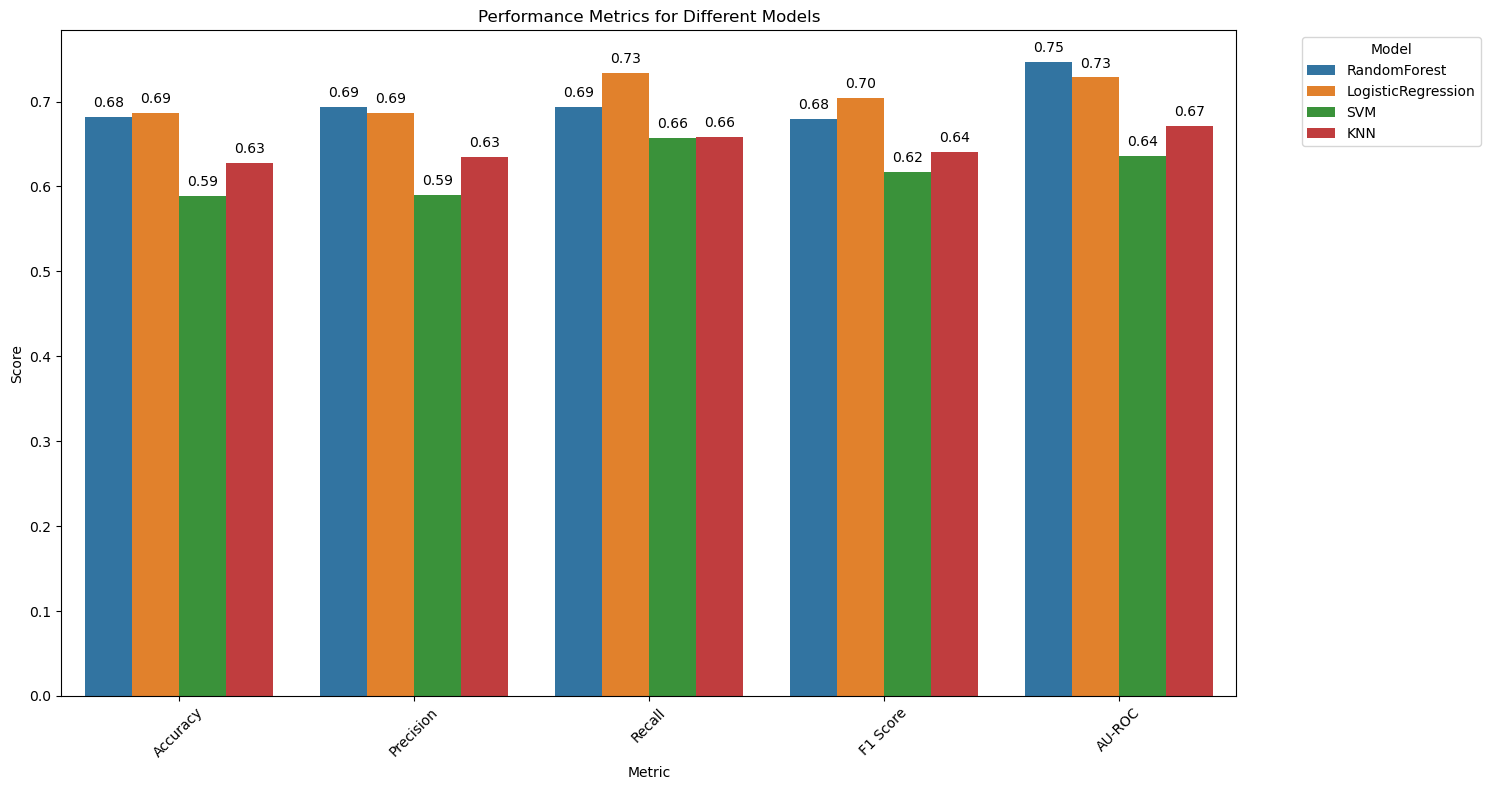

ValueError: Image size of 693971x418 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [52]:
# Plotting
plt.figure(figsize=(15, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
# Add labels on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'),  # format the value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha='center', va='center',
                xytext=(0, 10),  # 10 points vertical offset
                textcoords='offset points')
plt.title('Performance Metrics for Different Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# Manually setting the x-ticks
plot.set_xticks(range(len(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])))
plot.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print values on top
for index, row in df_long.iterrows():
    plt.text(row.name, row.Score, round(row.Score, 2), color='black', ha="center")


In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Assume 'files' is defined
df_list = []

for file in files:
    data = pd.read_csv('../Processed Datasets/' + file)
    data = data[data['Winner'].isin([1, 2])]
    data['Winner'] = data['Winner'].replace(1, 0)
    data['Winner'] = data['Winner'].replace(2, 1)

    label_encoders = {}
    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    for per in range(1, 11):
        percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per / 10)
        def find_nearest_row(group):
            nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
            return group.loc[[nearest_index]]
        nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)
        nearest_rows.reset_index(drop=True, inplace=True)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(nearest_rows.drop('Winner', axis=1))
        y = nearest_rows['Winner'].values

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


        # TensorFlow models within your existing loop
        models = {
            'NeuralNetwork': tf.keras.models.Sequential([
                        tf.keras.layers.Dense(250, activation='sigmoid', input_shape=(X_train.shape[1],)),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.Dense(125, activation='sigmoid'),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.Dense(1, activation='sigmoid')
            ]),
            'LSTM': Sequential([
                LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
                Dropout(0.2),
                LSTM(50),
                Dropout(0.2),
                Dense(1, activation='sigmoid') 
            ])
        }

        # Compile Keras models
        models['NeuralNetwork'].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        models['LSTM'].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        scores_dict = {'File': file, 'Percentile': per / 10}

        # Training and evaluation loop for Keras models
        for model_name, model in models.items():
            if model_name == 'LSTM':
                X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
                X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
                model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
                predictions = model.predict(X_test_reshaped)
            else:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
                predictions = model.predict(X_test)


            # Post-processing for metrics calculation
            predictions = (predictions > 0.5).astype(int)
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)
            roc = roc_auc_score(y_test, predictions)

            scores_dict[f'{model_name}_accuracy'] = accuracy
            scores_dict[f'{model_name}_precision'] = precision
            scores_dict[f'{model_name}_recall'] = recall
            scores_dict[f'{model_name}_f1'] = f1
            scores_dict[f'{model_name}_rocauc'] = roc

            df_list.append(pd.DataFrame([scores_dict]))



Epoch 1/50
8/8 [==============================] - 0s 25ms/step - loss: 0.7321 - accuracy: 0.4784 - val_loss: 0.7036 - val_accuracy: 0.4237
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5431 - val_loss: 0.7403 - val_accuracy: 0.4068
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6848 - accuracy: 0.5345 - val_loss: 0.6899 - val_accuracy: 0.5085
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6711 - accuracy: 0.5733 - val_loss: 0.6743 - val_accuracy: 0.5932
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6575 - accuracy: 0.6250 - val_loss: 0.7454 - val_accuracy: 0.4237
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6484 - accuracy: 0.6250 - val_loss: 0.6721 - val_accuracy: 0.5932
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6325 - accuracy: 0.6638 - val_loss: 0.7000 - val_accuracy: 0.5424
Epoch 8/50
8/8 [=================

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
12/12 [==============================] - 0s 15ms/step - loss: 0.7667 - accuracy: 0.4570 - val_loss: 0.6811 - val_accuracy: 0.6596
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6973 - accuracy: 0.5618 - val_loss: 0.6782 - val_accuracy: 0.5106
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6654 - accuracy: 0.6048 - val_loss: 0.6595 - val_accuracy: 0.6702
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6761 - accuracy: 0.6022 - val_loss: 0.6486 - val_accuracy: 0.6702
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6694 - val_loss: 0.6439 - val_accuracy: 0.7021
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6909 - val_loss: 0.6323 - val_accuracy: 0.7128
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.5795 - accuracy: 0.7258 - val_loss: 0.6300 - val_accuracy: 0.6915
Epoch 8/50
12/12 [=

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
12/12 [==============================] - 0s 17ms/step - loss: 0.7342 - accuracy: 0.5161 - val_loss: 0.7075 - val_accuracy: 0.5213
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.7059 - accuracy: 0.5215 - val_loss: 0.6952 - val_accuracy: 0.4787
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.6643 - accuracy: 0.5887 - val_loss: 0.6630 - val_accuracy: 0.6064
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6553 - accuracy: 0.5806 - val_loss: 0.6690 - val_accuracy: 0.5638
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6640 - val_loss: 0.6448 - val_accuracy: 0.6170
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6159 - accuracy: 0.6801 - val_loss: 0.6412 - val_accuracy: 0.6915
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 0.5790 - accuracy: 0.6989 - val_loss: 0.6296 - val_accuracy: 0.6809
Epoch 8/50
12/12 

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
4/4 [==============================] - 0s 44ms/step - loss: 0.7328 - accuracy: 0.4860 - val_loss: 0.6926 - val_accuracy: 0.5556
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.7155 - accuracy: 0.5421 - val_loss: 0.6856 - val_accuracy: 0.5556
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6819 - accuracy: 0.5514 - val_loss: 0.6824 - val_accuracy: 0.5926
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6809 - accuracy: 0.6075 - val_loss: 0.6836 - val_accuracy: 0.4815
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6622 - accuracy: 0.6075 - val_loss: 0.6768 - val_accuracy: 0.5926
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6626 - accuracy: 0.6075 - val_loss: 0.6752 - val_accuracy: 0.5556
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6315 - accuracy: 0.6075 - val_loss: 0.6750 - val_accuracy: 0.5556
Epoch 8/50
4/4 [================

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
4/4 [==============================] - 0s 44ms/step - loss: 0.7416 - accuracy: 0.4579 - val_loss: 0.6919 - val_accuracy: 0.5556
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6756 - accuracy: 0.5327 - val_loss: 0.6878 - val_accuracy: 0.5556
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6729 - accuracy: 0.5888 - val_loss: 0.6855 - val_accuracy: 0.4815
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6805 - accuracy: 0.5514 - val_loss: 0.6800 - val_accuracy: 0.5926
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6459 - accuracy: 0.5701 - val_loss: 0.6793 - val_accuracy: 0.5185
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6500 - accuracy: 0.5701 - val_loss: 0.6796 - val_accuracy: 0.5185
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6377 - accuracy: 0.5794 - val_loss: 0.6799 - val_accuracy: 0.5185
Epoch 8/50
2/2 [===============

KeyboardInterrupt: 

In [87]:
roc_auc_score(y_test, predictions)  # Eansure predictions are probabilities for ROC AUC

0.49830508474576274

In [96]:
df_list

[                         File  Percentile  NeuralNetwork_accuracy  \
 0  1D_All_ReplaysData_PvP.csv         0.1                0.657534   
 
    NeuralNetwork_precision  NeuralNetwork_recall  NeuralNetwork_f1  \
 0                 0.658537              0.710526          0.683544   
 
    NeuralNetwork_rocauc  
 0              0.655263  ,
                          File  Percentile  NeuralNetwork_accuracy  \
 0  1D_All_ReplaysData_PvP.csv         0.1                0.657534   
 
    NeuralNetwork_precision  NeuralNetwork_recall  NeuralNetwork_f1  \
 0                 0.658537              0.710526          0.683544   
 
    NeuralNetwork_rocauc  LSTM_accuracy  LSTM_precision  LSTM_recall   LSTM_f1  \
 0              0.655263       0.520548        0.520548          1.0  0.684685   
 
    LSTM_rocauc  
 0          0.5  ,
                          File  Percentile  NeuralNetwork_accuracy  \
 0  1D_All_ReplaysData_PvP.csv         0.2                0.616438   
 
    NeuralNetwork_precision 

C:\Users\abhin\AppData\Local\Temp\ipykernel_31476\801015304.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

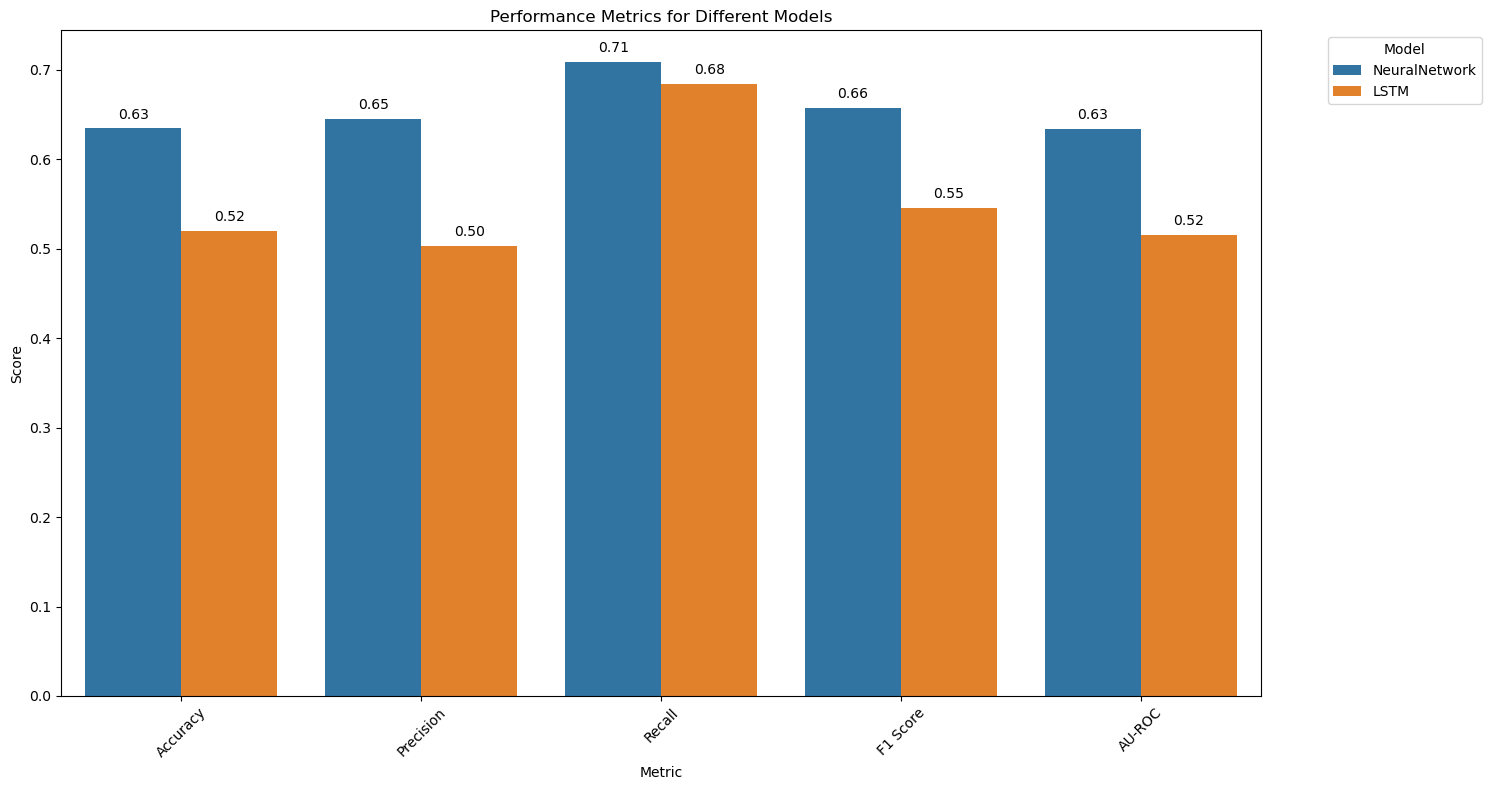

In [98]:
df = pd.concat(df_list, ignore_index=True)

df_long = pd.DataFrame()

# Pivot the DataFrame for plotting
df_long = pd.melt(df, id_vars=['File', 'Percentile'], var_name='Model_Metric', value_name='Score')

# Split the 'Model_Metric' into separate 'Model' and 'Metric' columns
df_long[['Model', 'Metric']] = df_long['Model_Metric'].str.rsplit('_', n=1, expand=True)

# Plotting
plt.figure(figsize=(15, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
# Add labels on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'),  # format the value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha='center', va='center',
                xytext=(0, 10),  # 10 points vertical offset
                textcoords='offset points')
plt.title('Performance Metrics for Different Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# Manually setting the x-ticks
plot.set_xticks(range(len(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])))
plot.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score','AU-ROC'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Time Based Model Metrics

In [99]:
# Initialize an empty list to store DataFrames to concatenate later.
df_list = []

for file in files:
    data = pd.read_csv('../Processed Datasets/' + file)
    data = data[data['Winner'].isin([1, 2])]
    data['Winner'] = data['Winner'].replace(1, 0)
    data['Winner'] = data['Winner'].replace(2, 1)

    label_encoders = {}
    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])
    # Apply the function to each group of 'ReplayID' and concatenate the results
    nearest_rows = data[data['Frame'] == 1800*10]

    # scaler = StandardScaler()
    # nearest_rows[nearest_rows.columns.drop(['Winner'])] = scaler.fit_transform(nearest_rows[nearest_rows.columns.drop(['Winner'])])

    X = nearest_rows.drop('Winner', axis=1)
    y = nearest_rows['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'RandomForest': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=12, max_features=23, min_samples_split=30, random_state=63),
        'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=1000, C=0.1, penalty='l1'),
        'SVM': svm.LinearSVC(C=0.00001, random_state=42, dual=False, max_iter=1000),
        'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance'),
    }

    # Dictionary to hold scores for the models
    scores_dict = {'File': file, 'Percentile': per / 10}

    for model_name, model in models.items():
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        scores = cross_validate(model, X, y, cv=5, scoring=metrics)
        for metric in metrics:
            scores_dict[f'{model_name}_{metric}'] = scores['test_' + metric].mean()
        roc = cross_validate(model, X, y, cv=5, scoring="roc_auc")
        scores_dict[f'{model_name}_roc'] = roc['test_' + 'score'].mean()
        

    # Append the scores_dict as a DataFrame to df_list
    df_list.append(pd.DataFrame([scores_dict]))

df = pd.concat(df_list, ignore_index=True)

# Pivot the DataFrame for plotting
df_long = pd.melt(df, id_vars=['File', 'Percentile'], var_name='Model_Metric', value_name='Score')

# Split the 'Model_Metric' into separate 'Model' and 'Metric' columns
df_long[['Model', 'Metric']] = df_long['Model_Metric'].str.rsplit('_', n=1, expand=True)



c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\abhin\AppData\Local\Temp\ipykernel_31476\2494723424.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

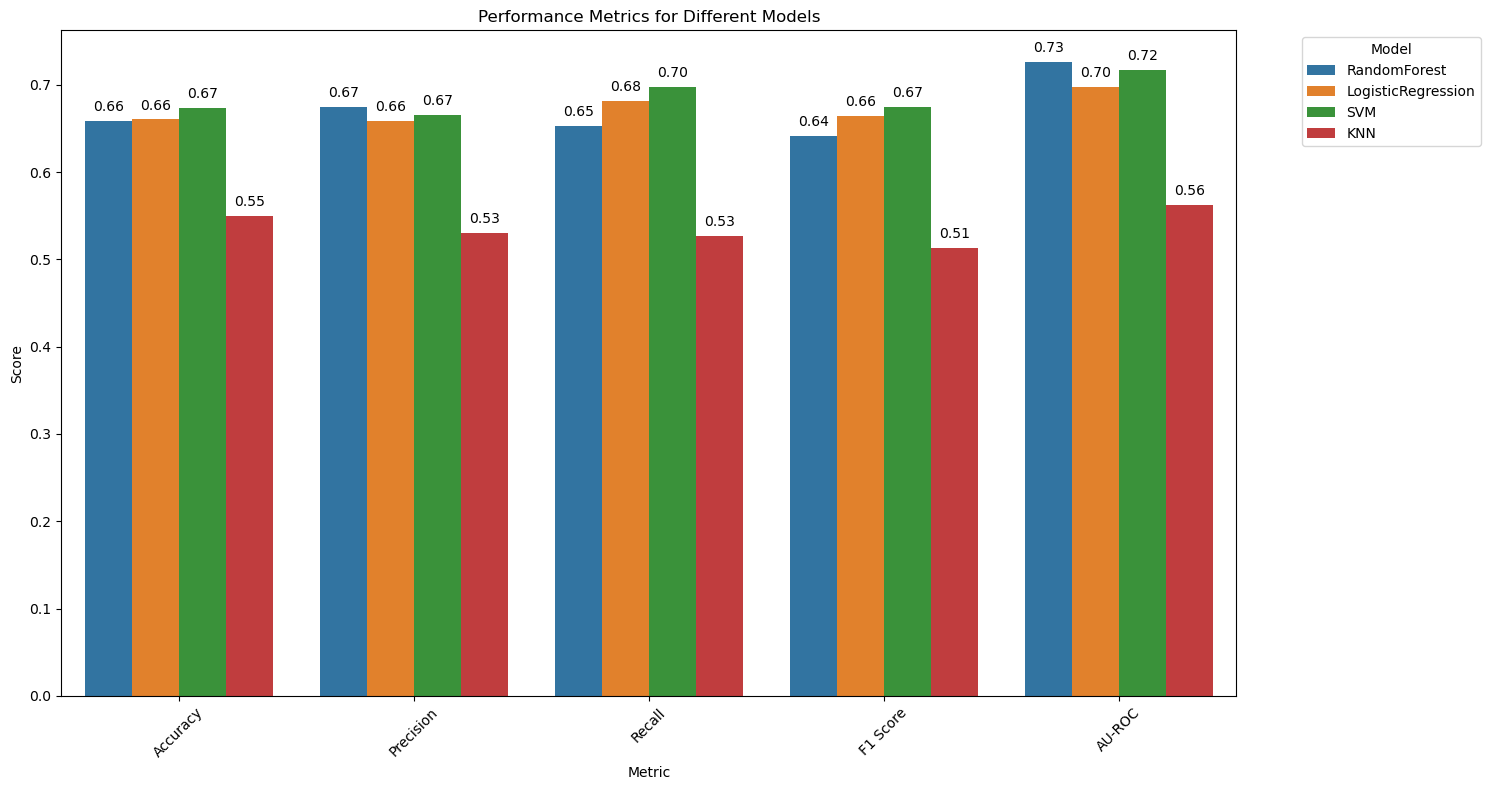

In [100]:
# Plotting
plt.figure(figsize=(15, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
# Add labels on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'),  # format the value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha='center', va='center',
                xytext=(0, 10),  # 10 points vertical offset
                textcoords='offset points')
plt.title('Performance Metrics for Different Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# Manually setting the x-ticks
plot.set_xticks(range(len(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])))
plot.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Deep learning time based

In [113]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Assume 'files' is defined
df_list = []

for file in files:
    data = pd.read_csv('../Processed Datasets/' + file)
    data = data[data['Winner'].isin([1, 2])]
    data['Winner'] = data['Winner'].replace(1, 0)
    data['Winner'] = data['Winner'].replace(2, 1)

    label_encoders = {}
    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    for per in range(1, 11):
        percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per / 10)
        def find_nearest_row(group):
            nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
            return group.loc[[nearest_index]]
        nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)
        nearest_rows.reset_index(drop=True, inplace=True)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(nearest_rows.drop('Winner', axis=1))
        y = nearest_rows['Winner'].values

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


        # TensorFlow models within your existing loop
        models = {
            'NeuralNetwork': tf.keras.models.Sequential([
                        tf.keras.layers.Dense(250, activation='sigmoid', input_shape=(X_train.shape[1],)),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.Dense(125, activation='sigmoid'),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.Dense(1, activation='sigmoid')
            ]),
        }

        # Compile Keras models
        models['NeuralNetwork'].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        scores_dict = {'File': file, 'Percentile': per / 10}

        # Training and evaluation loop for Keras models
        for model_name, model in models.items():
            model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
            predictions = model.predict(X_test)


            # Post-processing for metrics calculation
            predictions = (predictions > 0.5).astype(int)
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)
            roc = roc_auc_score(y_test, predictions)

            scores_dict[f'{model_name}_accuracy'] = accuracy
            scores_dict[f'{model_name}_precision'] = precision
            scores_dict[f'{model_name}_recall'] = recall
            scores_dict[f'{model_name}_f1'] = f1
            scores_dict[f'{model_name}_roc'] = roc

            df_list.append(pd.DataFrame([scores_dict]))


df2 = pd.concat(df_list, ignore_index=True)



Epoch 1/50
8/8 [==============================] - 0s 23ms/step - loss: 0.6938 - accuracy: 0.5216 - val_loss: 0.7466 - val_accuracy: 0.4068
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6974 - accuracy: 0.5172 - val_loss: 0.6983 - val_accuracy: 0.5254
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6814 - accuracy: 0.5776 - val_loss: 0.7429 - val_accuracy: 0.4068
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.5819 - val_loss: 0.6882 - val_accuracy: 0.5424
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6814 - accuracy: 0.5302 - val_loss: 0.6855 - val_accuracy: 0.5424
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6336 - accuracy: 0.6336 - val_loss: 0.7575 - val_accuracy: 0.4237
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6295 - accuracy: 0.6767 - val_loss: 0.6793 - val_accuracy: 0.5424
Epoch 8/50
8/8 [=================

In [112]:
df

,File,Percentile,RandomForest_accuracy,RandomForest_precision,RandomForest_recall,RandomForest_f1,RandomForest_roc,LogisticRegression_accuracy,LogisticRegression_precision,LogisticRegression_recall,...,SVM_accuracy,SVM_precision,SVM_recall,SVM_f1,SVM_roc,KNN_accuracy,KNN_precision,KNN_recall,KNN_f1,KNN_roc
0,1D_All_ReplaysData_PvP.csv,0.5,0.767213,0.805746,0.709892,0.745969,0.848387,0.747541,0.739514,0.763441,...,0.754098,0.753870,0.756344,0.753981,0.803871,0.616393,0.614211,0.638280,0.623783,0.659355
1,1D_All_ReplaysData_PvT.csv,0.5,0.760720,0.753776,0.797494,0.773494,0.828082,0.793782,0.791385,0.818296,...,0.773479,0.770230,0.804073,0.785933,0.840720,0.556303,0.563469,0.630201,0.593883,0.573570
2,1D_All_ReplaysData_PvZ.csv,0.5,0.534781,0.541065,0.651652,0.580238,0.574765,0.540297,0.552144,0.597598,...,0.562598,0.568636,0.640841,0.593426,0.595273,0.504421,0.515632,0.514414,0.512377,0.487078
3,1D_All_ReplaysData_TvT.csv,0.5,0.717474,0.710619,0.732101,0.720431,0.790521,0.723354,0.726062,0.726050,...,0.709110,0.704540,0.726387,0.712177,0.774953,0.484182,0.480759,0.534958,0.505873,0.481767
4,1D_All_ReplaysData_TvZ.csv,0.5,0.554645,0.668329,0.592803,0.530847,0.588706,0.557541,0.578049,0.702083,...,0.587322,0.604483,0.738826,0.658522,0.586793,0.557923,0.577941,0.689394,0.626311,0.566626
5,1D_All_ReplaysData_ZvZ.csv,0.5,0.621053,0.544444,0.510714,0.521066,0.708983,0.578947,0.523889,0.510714,...,0.642105,0.565202,0.532143,0.533998,0.669697,0.557895,0.383333,0.103571,0.154141,0.565152
6,StarCraft_Combined_Dataset.csv,0.5,0.655821,0.698126,0.572222,0.617250,0.742419,0.679703,0.696302,0.654762,...,0.681733,0.690418,0.680952,0.685424,0.745241,0.570562,0.579449,0.577778,0.578196,0.601475


C:\Users\abhin\AppData\Local\Temp\ipykernel_31476\338515508.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

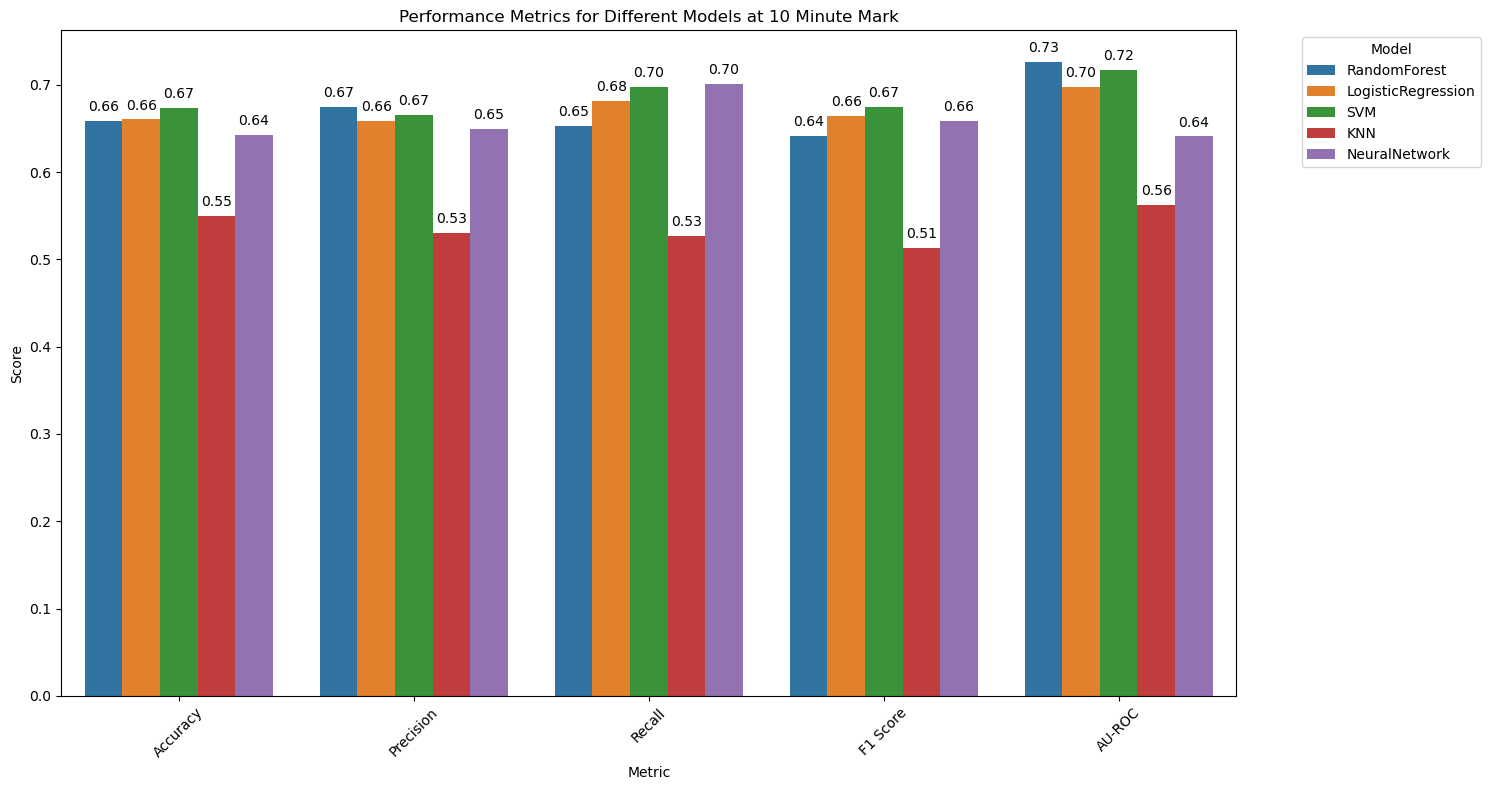

In [115]:
# add previous df and current df and combine it
finalDf = pd.concat([df, df2])

# Pivot the DataFrame for plotting
df_long = pd.melt(finalDf, id_vars=['File', 'Percentile'], var_name='Model_Metric', value_name='Score')

# Split the 'Model_Metric' into separate 'Model' and 'Metric' columns
df_long[['Model', 'Metric']] = df_long['Model_Metric'].str.rsplit('_', n=1, expand=True)



plt.figure(figsize=(15, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_long,  ci=None)
# Add labels on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'),  # format the value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha='center', va='center',
                xytext=(0, 10),  # 10 points vertical offset
                textcoords='offset points')
plt.title('Performance Metrics for Different Models at 10 Minute Mark')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# Manually setting the x-ticks
plot.set_xticks(range(len(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])))
plot.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AU-ROC'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()